In [2]:
%load_ext autoreload
%autoreload 2

from mcmc_lotte import *
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import csv
import pandas as pd
import itertools
import scipy.stats as st

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
test_name = 'lotte_test'

## System size

In [259]:
ns = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_iterations = 5000
runs = 15
temperatures = np.linspace(1, 100, 100)

tcs = np.zeros(len(ns))
tcs_std = np.zeros(len(ns))
peaks = np.zeros(len(ns))
peaks_std = np.zeros(len(ns))

for i, n in enumerate(ns):  
    tc = np.zeros(runs)
    peak = np.zeros(runs)
    for j in range(0, runs):
        sus = np.zeros(len(temperatures))
        for k, T in enumerate(temperatures):
            J = conn_matrix_basic(n)
            spins = random_spins(n)
            spins, avg_magnetisation, sus[k], spins_timeseries = metropolis(spins, n_iterations, T, J)
        idx = np.argmax(sus)
        tc[j] = temperatures[idx]
        peak[j] = sus[idx]

    tcs[i] = np.mean(tc)
    tcs_std[i] = np.std(tc)
    peaks[i] = np.mean(peak)
    peaks_std[i] = np.std(peak)       

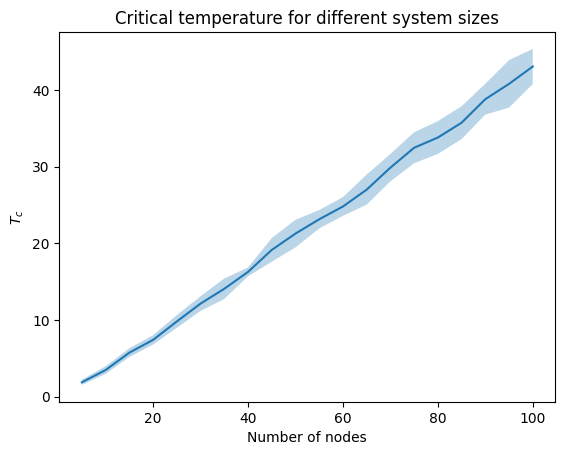

In [261]:
lower_bound = np.subtract(tcs, tcs_std)
upper_bound = np.add(tcs, tcs_std)
    
plt.plot(ns, tcs)
plt.fill_between(ns,lower_bound, upper_bound, alpha=0.3)

plt.xlabel('Number of nodes')
plt.ylabel(r'$T_c$')
plt.title('Critical temperature for different system sizes')
plt.savefig('critical_t_system_size.png')

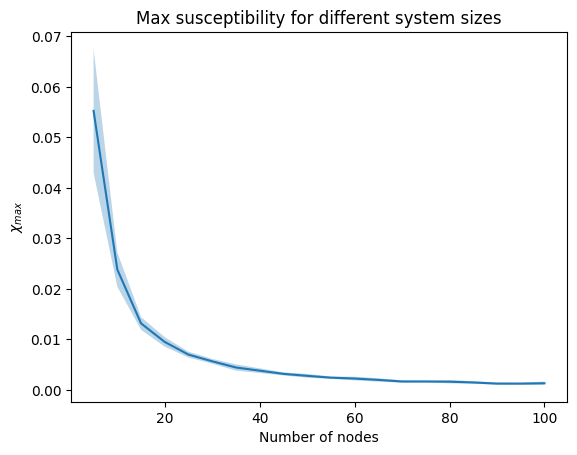

In [263]:
lower_bound = np.subtract(peaks, peaks_std)
upper_bound = np.add(peaks, peaks_std)

plt.plot(ns, peaks)
plt.fill_between(ns,lower_bound, upper_bound, alpha=0.3)

plt.xlabel('Number of nodes')
plt.ylabel(r'$\chi_{max}$')
plt.title('Max susceptibility for different system sizes')
plt.savefig('max_sus_system_size.png')

In [43]:
n = 10
temperatures = np.linspace(1, 50, 30)
J = conn_matrix_basic(n)
sim_data_10 = run_simulation(10, 10000, temperatures, n, J)
idx = np.argmax(sim_data_10[2])
tc_10 = temperatures[idx]

n = 25
J = conn_matrix_basic(n)
sim_data_25 = run_simulation(10, 10000, temperatures, n, J)
idx = np.argmax(sim_data_25[2])
tc_25 = temperatures[idx]

n = 50
J = conn_matrix_basic(n)
sim_data_50 = run_simulation(10, 10000, temperatures, n, J)
idx = np.argmax(sim_data_50[2])
tc_50 = temperatures[idx]

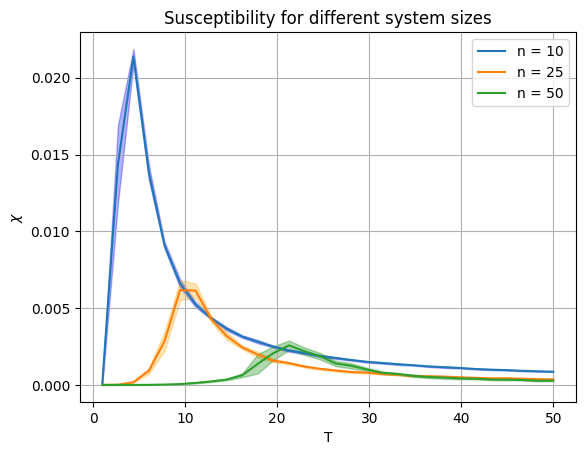

In [45]:
plt.plot(temperatures, sim_data_10[2], label = 'n = 10')
lower_bound_10 = np.subtract(sim_data_10[2], sim_data_10[3])
upper_bound_10 = np.add(sim_data_10[2], sim_data_10[3])
plt.fill_between(temperatures, lower_bound_10, upper_bound_10, alpha=0.3, color = 'b')

plt.plot(temperatures, sim_data_25[2], label = 'n = 25')
lower_bound_25 = np.subtract(sim_data_25[2], sim_data_25[3])
upper_bound_25 = np.add(sim_data_25[2], sim_data_25[3])
plt.fill_between(temperatures, lower_bound_25, upper_bound_25, alpha=0.3, color = 'orange')

plt.plot(temperatures, sim_data_50[2], label = 'n = 50')
lower_bound_50 = np.subtract(sim_data_50[2], sim_data_50[3])
upper_bound_50 = np.add(sim_data_50[2], sim_data_50[3])
plt.fill_between(temperatures, lower_bound_50, upper_bound_50, alpha=0.3, color = 'g')


plt.ylabel(r'$\chi$')
plt.xlabel('T')
plt.title('Susceptibility for different system sizes')
plt.legend()
plt.grid()
plt.savefig('Sus_system_sizes.png', bbox_inches = 'tight')

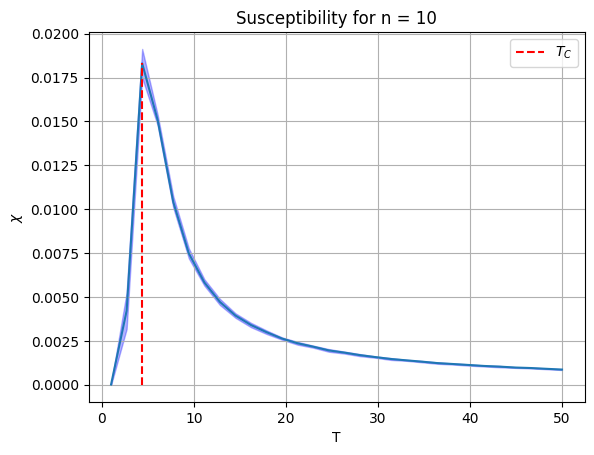

In [37]:
n = 10
temperatures = np.linspace(1, 50, 30)
J = conn_matrix_basic(n)
sim_data = run_simulation(15, 10000, temperatures, n, J)
idx = np.argmax(sim_data[2])
tc = temperatures[idx]

plt.plot(temperatures, sim_data[2])
lower_bound = np.subtract(sim_data[2], sim_data[3])
upper_bound = np.add(sim_data[2], sim_data[3])
plt.fill_between(temperatures, lower_bound, upper_bound, alpha=0.3, color = 'b')
plt.ylabel(r'$\chi$')
plt.xlabel('T')
plt.title('Susceptibility for n = 10')
plt.grid()
plt.vlines(tc, 0, np.max(sim_data[2]), linestyles='dashed', colors='r', label = r'$T_C$')
plt.legend()
plt.savefig('Sus_basic.png', bbox_inches = 'tight')

## TE system sizes

In [47]:
# n = 10
temperatures = np.linspace(1, 50, 30)
runs = 10
n_iterations = 5000

n = 10
C_10 = []
C_std_10 = []
multi_sus_10 = []

for T in temperatures:
    x = np.zeros(runs)
    sus = np.zeros(runs)
    for i in range(0, runs):
        J = conn_matrix_power(n)
        spins = random_spins(n)        
        _, list_avg_magnetisation, sus[i], spins_timeseries = metropolis(spins, n_iterations, T, J) 
        x[i] = TE(spins_timeseries, J)
    C_std_10.append(np.std(x))
    C_10.append(np.abs(np.mean(x)))
    multi_sus_10.append(np.mean(sus))


In [48]:
# n = 25
n = 25
C_25 = []
C_std_25 = []
multi_sus_25 = []

for T in temperatures:
    x = np.zeros(runs)
    sus = np.zeros(runs)
    for i in range(0, runs):
        J = conn_matrix_power(n)
        spins = random_spins(n)        
        _, list_avg_magnetisation, sus[i], spins_timeseries = metropolis(spins, n_iterations, T, J) 
        x[i] = TE(spins_timeseries, J)
    C_std_25.append(np.std(x))
    C_25.append(np.abs(np.mean(x)))
    multi_sus_25.append(np.mean(sus))


In [49]:
# n = 50
n = 50
C_50 = []
C_std_50 = []
multi_sus_50 = []


for T in temperatures:
    x = np.zeros(runs)
    sus = np.zeros(runs)
    for i in range(0, runs):
        J = conn_matrix_power(n)
        spins = random_spins(n)        
        _, list_avg_magnetisation, sus[i], spins_timeseries = metropolis(spins, n_iterations, T, J) 
        x[i] = TE(spins_timeseries, J)
    C_std_50.append(np.std(x))
    C_50.append(np.abs(np.mean(x)))
    multi_sus_50.append(np.mean(sus))

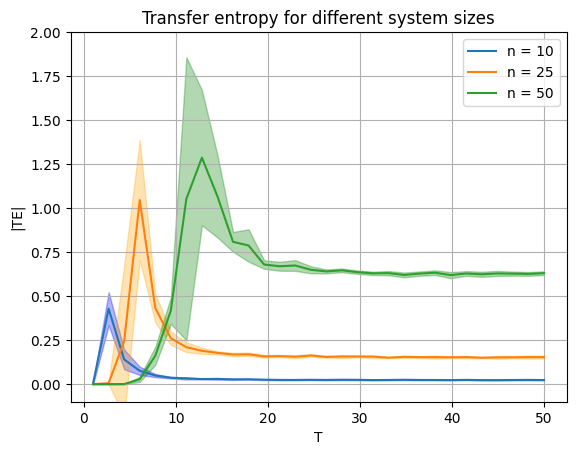

In [52]:
plt.plot(temperatures, C_10, label = 'n = 10')
plt.plot(temperatures, C_25, label = 'n = 25')
plt.plot(temperatures, C_50, label = 'n = 50')

lower_bound_10 = np.subtract(C_10, C_std_10)
upper_bound_10 = np.add(C_10, C_std_10)
plt.fill_between(temperatures, lower_bound_10, upper_bound_10, alpha=0.3, color = 'b')

lower_bound_25 = np.subtract(C_25, C_std_25)
upper_bound_25 = np.add(C_25, C_std_25)
plt.fill_between(temperatures, lower_bound_25, upper_bound_25, alpha=0.3, color = 'orange')

lower_bound_50 = np.subtract(C_50, C_std_50)
upper_bound_50 = np.add(C_50, C_std_50)
plt.fill_between(temperatures, lower_bound_50, upper_bound_50, alpha=0.3, color = 'g')

plt.legend()
plt.ylabel('|TE|')
plt.xlabel('T')
plt.grid()
plt.ylim(-0.1, 2)
plt.title('Transfer entropy for different system sizes')
plt.savefig('system_sizes_TE.png', bbox_inches='tight')

In [3]:
with open('DTI_avg.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    data = list(reader)
DTI = pd.DataFrame(data, dtype = 'float64')
dti_c_matrix = DTI.values

dti_c_matrix /= np.max(dti_c_matrix)

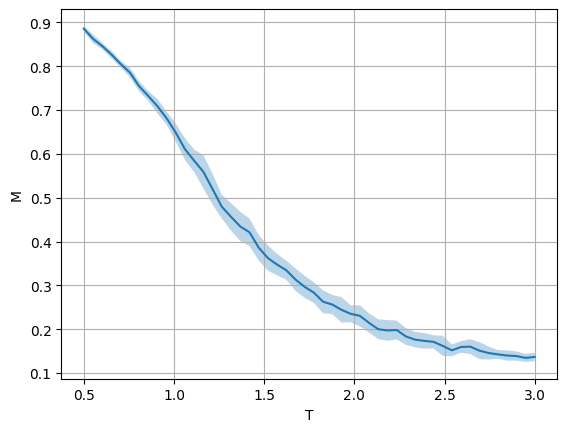

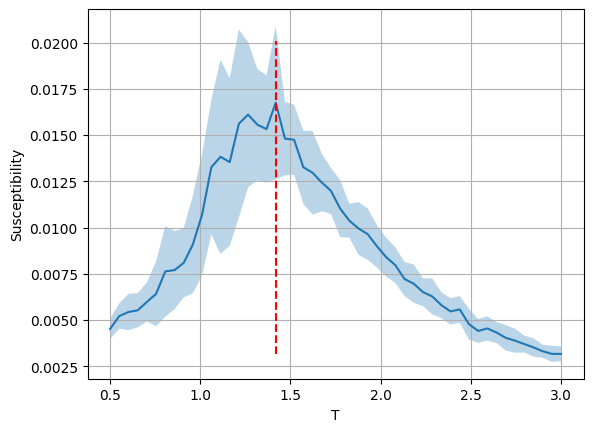

In [4]:
burn_in = 10000
n = 90
temperatures = np.linspace(0.5, 3, 50)
sim_data = run_simulation(20, 20000, temperatures, n, dti_c_matrix, burn_in)
idx = np.argmax(sim_data[2])
temperatures[idx]
plot_results(sim_data, temperatures, 'DTI', save=True)

In [19]:
runs = 10
C = []
C_std = []


for T in temperatures:
    x = np.zeros(runs)
    for i in range(0, runs):
        spins = random_spins(n)        
        _, list_avg_magnetisation, list_sus, spins_timeseries = metropolis(spins, n_iterations, T, J) 
        x[i] = TE(spins_timeseries, J)
    C_std.append(np.std(x))
    C.append(np.abs(np.mean(x)))

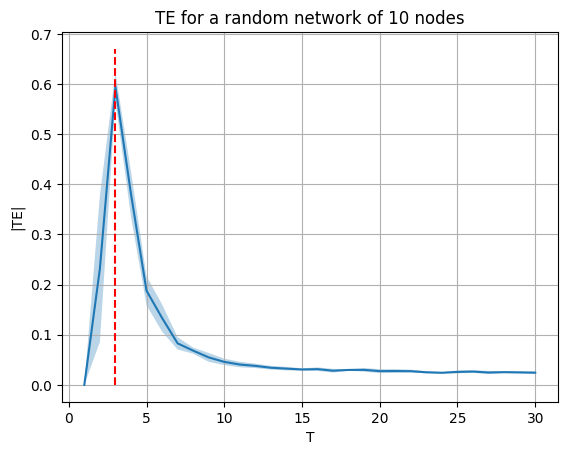

In [374]:
temperatures = np.linspace(1, 30, 30)
lower_bound = np.subtract(C, C_std)
upper_bound = np.add(C, C_std)
plt.plot(temperatures, C)
plt.fill_between(temperatures, lower_bound, upper_bound, alpha=0.3)

plt.ylabel('|TE|')
plt.xlabel('T')
plt.grid()
plt.title('TE for a random network of 10 nodes')
plt.vlines(tc, 0, 0.67, linestyles='dashed', colors='r')
plt.savefig('10_nodes_TE.png', bbox_inches='tight')

In [4]:
# DTI
n = 90
runs = 3
temperatures = np.linspace(0.5, 5, 20)
n_iterations = 5000

C_dti = []
C_std_dti = []
multi_sus_dti = []


for T in temperatures:
    x = np.zeros(runs)
    sus = np.zeros(runs)
    for i in range(0, runs):
        J = conn_matrix_norm(n)
        spins = random_spins(n)        
        _, list_avg_magnetisation, sus[i], spins_timeseries = metropolis(spins, n_iterations, T, J) 
        x[i] = TE(spins_timeseries, J)
    C_std_dti.append(np.std(x))
    C_dti.append(np.abs(np.mean(x)))
    multi_sus_dti.append(np.mean(sus))

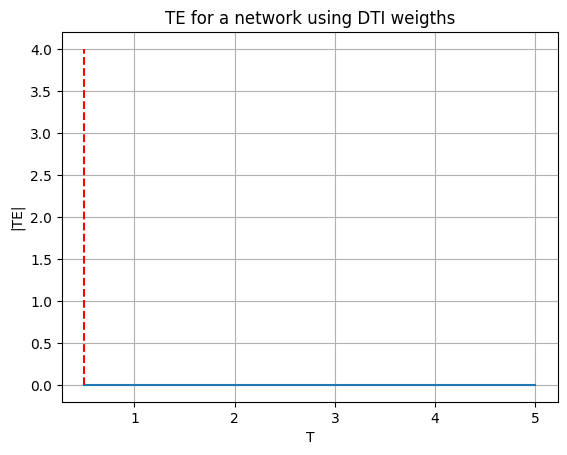

In [5]:
tc = temperatures[np.argmax(multi_sus_dti)]
lower_bound = np.subtract(C_dti, C_std_dti)
upper_bound = np.add(C_dti, C_std_dti)
plt.plot(temperatures, C_dti)
plt.fill_between(temperatures, lower_bound, upper_bound, alpha=0.3)

plt.ylabel('|TE|')
plt.xlabel('T')
plt.grid()
plt.title('TE for a network using DTI weigths')
plt.vlines(tc, 0, 4, linestyles='dashed', colors='r')
# plt.savefig('10_nodes_TE.png', bbox_inches='tight')

In [ ]:
# uniform
n = 10
runs = 30
temperatures = np.linspace(1, 15, 30)
n_iterations = 10000

peaks_uni = np.zeros(runs)

for i in range(0, runs):
    x = np.zeros(len(temperatures))
    for j, T in enumerate(temperatures):
        
        J = conn_matrix_basic(n)
        spins = random_spins(n)        
        _, list_avg_magnetisation, sus, spins_timeseries = metropolis(spins, n_iterations, T, J) 
        x[j] = TE(spins_timeseries, J)
    peaks_uni[i] = np.max(np.abs(x))

In [8]:
# normal
n = 10
runs = 30
temperatures = np.linspace(1, 15, 30)
n_iterations = 10000

peaks_norm = np.zeros(runs)

for i in range(0, runs):
    x = np.zeros(len(temperatures))
    for j, T in enumerate(temperatures):
        
        J = conn_matrix_norm(n)
        spins = random_spins(n)        
        _, list_avg_magnetisation, sus, spins_timeseries = metropolis(spins, n_iterations, T, J) 
        x[j] = TE(spins_timeseries, J)
    peaks_norm[i] = np.max(np.abs(x))

In [6]:
# powerlaw
n = 10
runs = 30
temperatures = np.linspace(1, 15, 30)
n_iterations = 10000

peaks_power = np.zeros(runs)

for i in range(0, runs):
    x = np.zeros(len(temperatures))
    for j, T in enumerate(temperatures):
        
        J = conn_matrix_power(n)
        spins = random_spins(n)        
        _, list_avg_magnetisation, sus, spins_timeseries = metropolis(spins, n_iterations, T, J) 
        x[j] = TE(spins_timeseries, J)
    peaks_power[i] = np.max(np.abs(x))

In [7]:
st.shapiro(peaks_uni), st.shapiro(peaks_norm), st.shapiro(peaks_power)

NameError: name 'peaks_uni' is not defined

In [103]:
peaks_uni, peaks_norm, peaks_power

(array([0.55860337, 0.57231538, 0.53949444, 0.54727251, 0.5945177 ,
        0.58238235, 0.55653735, 0.55914855, 0.58475814, 0.55160556,
        0.57487545, 0.56519022, 0.58810745, 0.5716478 , 0.54708833,
        0.52093639, 0.5790485 , 0.59105104, 0.58485551, 0.59465782,
        0.55941534, 0.61126429, 0.50231446, 0.62618835, 0.59941553,
        0.50648175, 0.52421413, 0.5743892 , 0.51476673, 0.56931457]),
 array([0.47945561, 0.50689762, 0.53798364, 0.60689169, 0.56924747,
        0.58798952, 0.54260698, 0.61242827, 0.53208155, 0.53940535,
        0.57990911, 0.56090613, 0.52694607, 0.56981232, 0.58053341,
        0.54244406, 0.52995628, 0.54158134, 0.59416168, 0.59450133,
        0.56619158, 0.58110568, 0.51292628, 0.59430646, 0.55036988,
        0.48550576, 0.57149538, 0.54473576, 0.5869711 , 0.5569274 ]),
 array([0.55525388, 0.59540118, 0.57579718, 0.56510702, 0.47129451,
        0.60039188, 0.52127135, 0.43195551, 0.55500207, 0.55079902,
        0.56470619, 0.5611647 , 0.53596377, 

In [105]:
st.kruskal(peaks_uni, peaks_norm, peaks_power)

KruskalResult(statistic=2.3118925518925266, pvalue=0.31475954654734184)

In [56]:
# uniform
n = 10
runs = 15
temperatures = np.linspace(1, 15, 30)
n_iterations = 10000

C_uni = []
C_std_uni = []
uni_low = []
uni_up = []
multi_sus_uni = []

for T in temperatures:
    x = np.zeros(runs)
    sus = np.zeros(runs)
    for i in range(0, runs):
        J = conn_matrix_basic(n)
        spins = random_spins(n)        
        _, list_avg_magnetisation, sus[i], spins_timeseries = metropolis(spins, n_iterations, T, J) 
        x[i] = TE(spins_timeseries, J)
    C_std_uni.append(np.std(x))
    C_uni.append(np.abs(np.mean(x)))
    multi_sus_uni.append(np.mean(sus))

In [57]:
# normal
n = 10
runs = 15
temperatures = np.linspace(1, 15, 30)
n_iterations = 10000

C_norm = []
C_std_norm = []
multi_sus_norm = []
norm_low = []
norm_up = []

for T in temperatures:
    x = np.zeros(runs)
    sus = np.zeros(runs)
    for i in range(0, runs):
        J = conn_matrix_norm(n)
        spins = random_spins(n)        
        _, list_avg_magnetisation, sus[i], spins_timeseries = metropolis(spins, n_iterations, T, J) 
        x[i] = TE(spins_timeseries, J)
    C_std_norm.append(np.std(x))
    C_norm.append(np.abs(np.mean(x)))
    multi_sus_norm.append(np.mean(sus))

In [58]:
# powerlaw
n = 10
runs = 15
temperatures = np.linspace(1, 15, 30)

n_iterations = 10000

C_power = []
C_std_power = []
multi_sus_power = []
power_low = []
power_up = []

for T in temperatures:
    x = np.zeros(runs)
    sus = np.zeros(runs)
    for i in range(0, runs):
        J = conn_matrix_power(n)
        spins = random_spins(n)        
        _, list_avg_magnetisation, sus[i], spins_timeseries = metropolis(spins, n_iterations, T, J) 
        x[i] = TE(spins_timeseries, J)
    C_std_power.append(np.std(x))
    C_power.append(np.abs(np.mean(x)))
    multi_sus_power.append(np.mean(sus))

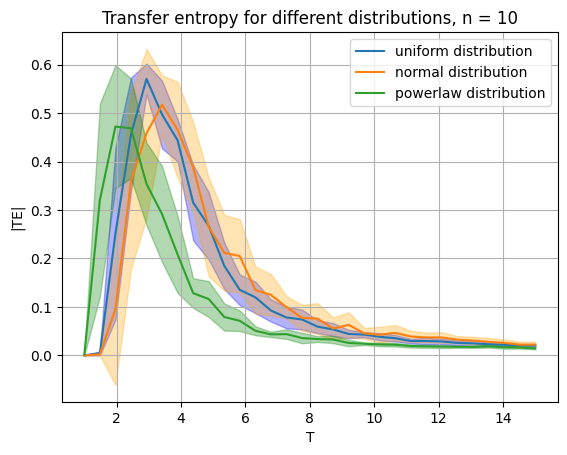

In [59]:
plt.plot(temperatures, C_uni, label = 'uniform distribution')
plt.plot(temperatures, C_norm, label = 'normal distribution')
plt.plot(temperatures, C_power, label = 'powerlaw distribution')

lower_bound_uni = np.subtract(C_uni, C_std_uni)
upper_bound_uni = np.add(C_uni, C_std_uni)
plt.fill_between(temperatures, lower_bound_uni, upper_bound_uni, alpha=0.3, color = 'b')

lower_bound_norm = np.subtract(C_norm, C_std_norm)
upper_bound_norm = np.add(C_norm, C_std_norm)

plt.fill_between(temperatures, lower_bound_norm, upper_bound_norm, alpha=0.3, color = 'orange')

lower_bound_power = np.subtract(C_power, C_std_power)
upper_bound_power = np.add(C_power, C_std_power)
plt.fill_between(temperatures, lower_bound_power, upper_bound_power, alpha=0.3, color = 'g')

plt.legend()
plt.ylabel('|TE|')
plt.xlabel('T')
plt.grid()
plt.title('Transfer entropy for different distributions, n = 10')
plt.savefig('distributions_TE.png', bbox_inches='tight')

In [245]:
n = 10
temperatures = np.linspace(1, 15, 30)
J = conn_matrix_basic(n)
sim_data_uni = run_simulation(15, 10000, temperatures, n, J)
idx = np.argmax(sim_data_uni[2])
tc_uni = temperatures[idx]


J_norm = conn_matrix_norm(n)
sim_data_norm = run_simulation(15, 10000, temperatures, n, J_norm)
idx = np.argmax(sim_data_norm[2])
tc_norm = temperatures[idx]

J_power = conn_matrix_power(n)
sim_data_power = run_simulation(15, 10000, temperatures, n, J_power)
idx = np.argmax(sim_data_power[2])
tc_power = temperatures[idx]

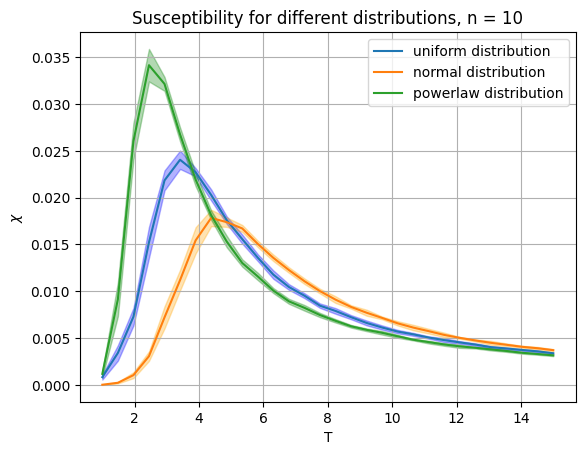

In [256]:
plt.plot(temperatures, sim_data_uni[2], label = 'uniform distribution')
lower_bound_uni = np.subtract(sim_data_uni[2], sim_data_uni[3])
upper_bound_uni = np.add(sim_data_uni[2], sim_data_uni[3])
plt.fill_between(temperatures, lower_bound_uni, upper_bound_uni, alpha=0.3, color = 'b')

plt.plot(temperatures, sim_data_norm[2], label = 'normal distribution')
lower_bound_norm = np.subtract(sim_data_norm[2], sim_data_norm[3])
upper_bound_norm = np.add(sim_data_norm[2], sim_data_norm[3])
plt.fill_between(temperatures, lower_bound_norm, upper_bound_norm, alpha=0.3, color = 'orange')

plt.plot(temperatures, sim_data_power[2], label = 'powerlaw distribution')
lower_bound_power = np.subtract(sim_data_power[2], sim_data_power[3])
upper_bound_power = np.add(sim_data_power[2], sim_data_power[3])
plt.fill_between(temperatures, lower_bound_power, upper_bound_power, alpha=0.3, color = 'g')


plt.ylabel(r'$\chi$')
plt.xlabel('T')
plt.title('Susceptibility for different distributions, n = 10')
plt.legend()
plt.grid()
plt.savefig('Sus_distributions.png', bbox_inches = 'tight')